# Spectrogram sandbox

This notebook is for experimenting with spectrogram parameters.

Ensure you have `ffprobe` available to your computer via your computer's package manager (`brew install ffprobe` on MacOS or `sudo apt-get install ffprobe` on Ubuntu, etc.)

In [3]:
orca_call_audio_url = "https://s3-us-west-2.amazonaws.com/streaming-orcasound-net/rpi_orcasound_lab/hls/1719430219/live322.ts"
fish_grunt_audio_url = "https://s3-us-west-2.amazonaws.com/streaming-orcasound-net/rpi_orcasound_lab/hls/1723491018/live516.ts"
ferry_vessel_audio_url = "https://s3-us-west-2.amazonaws.com/streaming-orcasound-net/rpi_north_sjc/hls/1723100418/live6160.ts"
hydrophone_hum_water_splashes_audio_url = "https://s3-us-west-2.amazonaws.com/streaming-orcasound-net/rpi_north_sjc/hls/1718175617/live7424.ts"

In [33]:
%pip install boto3
%pip install imutils 
%pip install librosa
%pip install matplotlib
%pip install numpy<2.0
%pip install opencv-python 
%pip install requests


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
/usr/local/bin/bash: line 1: 2.0: No such file or directory
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use up

In [ ]:
# Spectrogram generator via: https://github.com/kylemcdonald/AudioNotebooks/blob/master/Generating%20Spectrograms.ipynb

# Copyright (c) 2016- Kyle McDonald
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

import librosa
import matplotlib.pyplot as plt
import numpy as np
import cv2

class SpectrogramGenerator:
    """Create a spectrogram generator."""
    
    def __init__(self, sr,
                 n_fft=1024,
                 linear=False,
                 hop_length=None,
                 db_ref=0.01,
                 db_range=None,
                 fmin=None,
                 fmax=None,
                 cmap=None,
                 window='hann',
                 drop_nyquist=True,
                 flipud=True):
        """
        Args:
            sr (int): sample rate
            n_fft (int): size of STFT window in samples
            linear (bool): use linear instead of logarithmic frequency spacing
            hop_length (int): samples between STFT frames
            db_ref (float): `ref` parameter when converting amplitude to dB
            db_range (tuple): min and max dB for output
            fmin (float): minimum frequency to output (hertz)
            fmax (float): maximum frequency to output (hertz)
            cmap (str): matplotlib color map to use for output
            window (str): windowing function for STFT
            drop_nyquist (bool): if True, output has exactly `n_fft//2` bins
            flipud (bool): whether to flip the STFT output
        """

        self.n_fft = n_fft
        self.hop_length = hop_length
        self.db_ref = db_ref
        self.db_range = db_range
        self.cmap = cmap
        self.window = window
        self.drop_nyquist = drop_nyquist
        
        if hop_length is None:
            self.hop_length = n_fft // 4
        
        if cmap is not None:
            self.cmap = plt.get_cmap(cmap)
        
        bin_count = (n_fft // 2) + 1 
        if drop_nyquist:
            bin_count -= 1
        nyquist = sr // 2
        if fmin == None:
            min_bin = 1
        else:
            min_bin = (fmin / nyquist) * (bin_count - 1)
        if fmax == None:
            max_bin = bin_count - 1
        else:
            max_bin = (fmax / nyquist) * (bin_count - 1)
        bins = np.arange(bin_count)
        if linear:
            y_remap = (bins + min_bin) / ((bin_count - 1) / (max_bin - min_bin))
        else:
            scale_factor = bin_count / np.log10(max_bin / min_bin)
            y_remap = min_bin * 10 ** (bins / scale_factor)
        if flipud:
            y_remap = y_remap[::-1]
        self.mapy_base = y_remap.reshape(-1,1).astype(np.float32)
        
    def __call__(self, audio):
        """Generate a spectrogram for visualization.
        
        Returns:
            np.array of type np.uint8 if `db_range` or `cmap` is set, otherwise np.float32
        """
        stft = librosa.stft(audio,
                            n_fft=self.n_fft,
                            hop_length=self.hop_length,
                            window=self.window)
        if self.drop_nyquist:
            stft = stft[:-1]
        db = librosa.amplitude_to_db(np.abs(stft), ref=self.db_ref)
        mapx = np.arange(db.shape[1], dtype=np.float32).reshape(1,-1).repeat(db.shape[0], axis=0)
        mapy = self.mapy_base.repeat(db.shape[1], axis=1)
        out = cv2.remap(db, mapx, mapy, cv2.INTER_LANCZOS4)
        
        if self.db_range is not None:
            out -= self.db_range[0]
            out /= self.db_range[1] - self.db_range[0]
            
        if self.cmap is not None:
            if self.db_range is None:
                out -= out.min()
                out /= out.max()
            out = self.cmap(out)[...,:3]
            
        if self.cmap is not None or self.db_range is not None:
            out = np.clip(out * 256, 0, 255).astype(np.uint8)
            
        return out
        

In [4]:
from matplotlib.pyplot import imshow
from spectrogram_generator import SpectrogramGenerator
from subprocess import check_output
from typing import TypedDict, Optional
import boto3
import io
import json
import librosa
import matplotlib
import os.path


In [5]:
def get_audio_metadata(local_path):
    result = check_output(['ffprobe',
                            '-hide_banner', '-loglevel', 'panic',
                            '-show_format',
                            '-show_streams',
                            '-of',
                            'json', local_path])

    return json.loads(result)

In [34]:
def spectrogram(job, show_image=True, store_image=True):
    local_path = f"{job["id"]}.ts"
    s3 = boto3.client("s3")

    if not os.path.exists(local_path):
        response = s3.get_object(Bucket=job["audio_bucket"], Key=job["audio_key"])
        audio_bytes = response["Body"].read()
        with open(local_path, "wb") as file:
            file.write(audio_bytes)

    sample_rate = job.get("sample_rate")
    if sample_rate is None:
        metadata = get_audio_metadata(local_path)
        sample_rate = int(metadata["streams"][0]["sample_rate"])

    audio, sr = librosa.load(local_path, sr=sample_rate)

    generator = SpectrogramGenerator(sr,
                                 linear=False,
                                 n_fft=1024,
                                #  fmin=1,
                                #  fmax=20000,
                                 hop_length=256,
                                 db_range=(10, 80),
                                 cmap='inferno')
    spectrogram = generator(audio)
    if show_image:
        matplotlib.pyplot.axis('off')
        imshow(spectrogram)

    # Store spectrogram image either as a file or in-memory
    image_store = f"{job["id"]}.png" if store_image else io.BytesIO()
    matplotlib.image.imsave(image_store, spectrogram)
    if not store_image:
        image_store.seek(0)

In [36]:
from urllib.parse import urlparse

def s3_params(url):
  path_parts = urlparse(url).path.split("/")
  return {"bucket": path_parts.pop(1), "key": "/".join(path_parts)[1:]}


In [43]:
jobs = [
    {
        "id": "orca_call",
        "audio_bucket": s3_params(orca_call_audio_url)["bucket"],
        "audio_key": s3_params(orca_call_audio_url)["key"],
    },
    {
        "id": "fish_grunt",
        "audio_bucket": s3_params(fish_grunt_audio_url)["bucket"],
        "audio_key": s3_params(fish_grunt_audio_url)["key"],
    },
    {
        "id": "ferry_vessel",
        "audio_bucket": s3_params(ferry_vessel_audio_url)["bucket"],
        "audio_key": s3_params(ferry_vessel_audio_url)["key"],
    },
    {
        "id": "water_splash",
        "audio_bucket": s3_params(hydrophone_hum_water_splashes_audio_url)["bucket"],
        "audio_key": s3_params(hydrophone_hum_water_splashes_audio_url)["key"],
    },
]
orca = jobs[0]
fish = jobs[1]
ferry_vessel = jobs[2]
water_splash = jobs[3]
jobs

[{'id': 'orca_call',
  'audio_bucket': 'streaming-orcasound-net',
  'audio_key': 'rpi_orcasound_lab/hls/1719430219/live322.ts'},
 {'id': 'fish_grunt',
  'audio_bucket': 'streaming-orcasound-net',
  'audio_key': 'rpi_orcasound_lab/hls/1723491018/live516.ts'},
 {'id': 'ferry_vessel',
  'audio_bucket': 'streaming-orcasound-net',
  'audio_key': 'rpi_north_sjc/hls/1723100418/live6160.ts'},
 {'id': 'water_splash',
  'audio_bucket': 'streaming-orcasound-net',
  'audio_key': 'rpi_north_sjc/hls/1718175617/live7424.ts'}]

/var/folders/kt/w5yz129s35vg9wszmtt6c3400000gn/T/ipykernel_37525/2404741270.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(local_path, sr=sample_rate)
/Users/skander/.asdf/installs/python/3.12.4/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


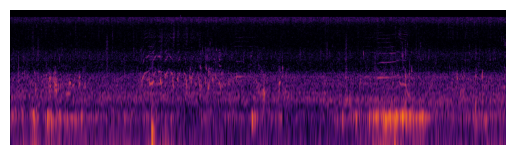

In [44]:
spectrogram(orca)